### Q-Learning, Double Q-learning and Dyna-Q Comparison

In [1]:
import gymnasium
import time
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import deque

#### Statistics functions

In [2]:
def sum_rewards(reward_per_episode, episodes_completed):
    """Returns the reward for last 100 episodes for each episode, to give the success rate of the algorithm.
       The maximum is 100, so a 0-100 scale is created, with 100 being the perfect score."""
    sum_of_rewards = np.zeros(episodes_completed)
    for i in range(episodes_completed):
        # Rewards for last 100 episodes.
        sum_of_rewards[i] = np.sum(reward_per_episode[max(0, i - 100):(i+1)])
    return sum_of_rewards

def cumulative_reward(rewards_per_episode):
    """Create a list of the cumulative reward the agent has gained per episode."""
    cumulative_reward = [rewards_per_episode[0]]
    for i in rewards_per_episode[1:]:
        cumulative_reward.append(i + cumulative_reward[-1])
    return cumulative_reward

### Standard Q-learning

Number of steps taken 90342, Violations: 971
Number of steps taken 84380, Violations: 792
Number of steps taken 113316, Violations: 2475
Number of steps taken 90457, Violations: 1140
Number of steps taken 94175, Violations: 1450
Number of steps taken 78429, Violations: 455
Number of steps taken 93223, Violations: 1251
Number of steps taken 80349, Violations: 566
Number of steps taken 114905, Violations: 2455
Number of steps taken 106443, Violations: 2101
Elapsed time is 29.77 seconds.
Average violations per run:  1365.6


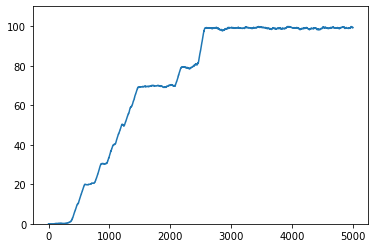

In [3]:
def frozen_lake(episodes, render=False, training=True):
    env = gymnasium.make("FrozenLake-v1", map_name="8x8", is_slippery=False, render_mode="human" if render else None) 
    actions = [0,1,2,3] # Actions the agent may take
    if training:
        q_table = np.zeros((env.observation_space.n, env.action_space.n))  # 64 states, 4 actions
        epsilon = 0.5 # The e-greedy randomisation starting rate.
        decay = 0.001  # Decay rate of epsilon each episode
        discount = 0.9
        learning_rate = 0.9 # Learning rate (new_q = (1- lr)*old_q + (lr)*new_q)
        
        # Statistic variables
        steps = 0
        episodes_completed = 0
        violations = 0
        
    reward_per_episode = []
    
    for i in range(episodes):
        state = env.reset()[0]  # Top left is where person will be ([0])
        terminated = False  # True is falls in hole or reaches goal
        truncated = False  # True if actions goes over 200
        reward = 0

        while not terminated and not truncated:
            if random.uniform(0, 1) > epsilon and any(q_table[state]):
                # Do the q-table action if one is available (if all q_table values are 0, no action is better than any other.)
                action = np.argmax(q_table[state])
                steps += 1 # Increment step counter
            else:
                # Random action
                action = env.action_space.sample() # # 0=left, 1=down, 2=right, 3=up
                steps += 1 # Increment step counter

            # Take action
            new_state, reward, terminated, truncated, info = env.step(action)

            # Update q-table
            q_table[state, action] = (1 - learning_rate) * q_table[state, action] + learning_rate * (reward + discount * np.max(q_table[new_state, :]))
            
            # New state becomes current state.
            state = new_state

        # Decrease epsilon after each episode to min of 0.02.
        epsilon = max(epsilon - decay, 0.02)
        
        # Track reward
        reward_per_episode.append(reward)
        if reward != 1 and not truncated:
            # No reward and not truncated (too many actions taken) menas that a violation has happened.
            violations += 1

        env.close()
        episodes_completed += 1
        
    print(f"Number of steps taken {steps}, Violations: {violations}")
                  
    return sum_rewards(reward_per_episode, episodes_completed), violations


t1 = time.time() # Start timer

all_rewards = []
all_violations = []
training_episodes = 5000
training_runs = 10
for i in range(training_runs):
    rewards, violations = frozen_lake(training_episodes)
    all_rewards.append(rewards)
    all_violations.append(violations)
t2 = time.time() # Stop timer
time_taken = t2 - t1 # Time taken
print(f'Elapsed time is {time_taken:.2f} seconds.')
print("Average violations per run: ", sum(all_violations)/training_runs)

average_rewards = []
for i in range(training_episodes):
    # Sum the runs and divide by number of runs to get the mean.
    total = sum([j[i] for j in all_rewards])
    average_rewards.append(total/training_runs)

plt.plot(average_rewards)
plt.ylim(0, 110)
plt.show()

### Double Q-learning

Number of steps taken 102706, Violations: 1851
Number of steps taken 101102, Violations: 1616
Number of steps taken 107219, Violations: 2144
Number of steps taken 124167, Violations: 3098
Number of steps taken 124978, Violations: 2908
Number of steps taken 129824, Violations: 3426
Number of steps taken 121484, Violations: 2863
Number of steps taken 120434, Violations: 2856
Number of steps taken 108852, Violations: 2238
Number of steps taken 105857, Violations: 2002
Elapsed time is 33.78 seconds.
Average violations per run:  2500.2


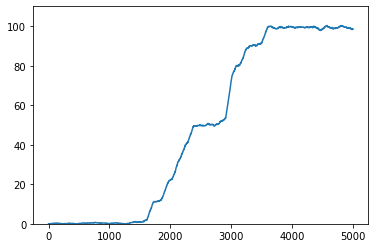

In [4]:
def frozen_lake(episodes, render=False, training=True):
    env = gymnasium.make("FrozenLake-v1", map_name="8x8", is_slippery=False, render_mode="human" if render else None) 
    actions = [0,1,2,3] # Actions the agent may take
    if training:
        q_table_a = np.zeros((env.observation_space.n, env.action_space.n))  # 64 states, 4 actions
        q_table_b = np.zeros((env.observation_space.n, env.action_space.n))  # 64 states, 4 actions
        epsilon = 0.5 # The e-greedy randomisation starting rate.
        decay = 0.001  # Decay rate of epsilon each episode
        discount = 0.9
        learning_rate = 0.9 # Learning rate (new_q = (1- lr)*old_q + (lr)*new_q)
        
        # Statistic variables
        steps = 0
        episodes_completed = 0
        violations = 0
        
    reward_per_episode = []
    
    for i in range(episodes):
        state = env.reset()[0]  # Top left is where person will be ([0])
        terminated = False  # True is falls in hole or reaches goal
        truncated = False  # True if actions goes over 200
        reward = 0

        while not terminated and not truncated:
            if random.uniform(0, 1) > epsilon and any(q_table_a[state] + q_table_b[state]):
                # Do the q-table action if one is available (if all q_table values are 0, no action is better than any other.)
                action = np.argmax(q_table_a[state] + q_table_b[state]) # Choose the maximum over the two combined tables.
                steps += 1 # Increment step counter
            else:
                # Random action
                action = env.action_space.sample() # # 0=left, 1=down, 2=right, 3=up
                steps += 1 # Increment step counter

            # Take action
            new_state, reward, terminated, truncated, info = env.step(action)
    
            # Update one of the q-tables
            if np.random.rand() < 0.5:
                # Update q_table_a
                q_table_a[state, action] = (1 - learning_rate) * q_table_a[state, action] + learning_rate * (reward + discount * q_table_b[new_state, np.argmax(q_table_a[new_state])])
            else:
                # Update q_table_b
                q_table_b[state, action] = (1 - learning_rate) * q_table_b[state, action] + learning_rate * (reward + discount * q_table_a[new_state, np.argmax(q_table_b[new_state])])
            
            # New state becomes current state.
            state = new_state

        # Decrease epsilon after each episode to min of 0.02.
        epsilon = max(epsilon - decay, 0.02)
        
        # Track reward
        reward_per_episode.append(reward)
        if reward != 1 and not truncated:
            # No reward and not truncated (too many actions taken) menas that a violation has happened.
            violations += 1

        env.close()
        episodes_completed += 1
        
    print(f"Number of steps taken {steps}, Violations: {violations}")
                  
    return sum_rewards(reward_per_episode, episodes_completed), violations

t1 = time.time() # Start timer
all_rewards = []
all_violations = []
training_episodes = 5000
training_runs = 10
for i in range(training_runs):
    rewards, violations = frozen_lake(training_episodes)
    all_rewards.append(rewards)
    all_violations.append(violations)
t2 = time.time() # Stop timer
time_taken = t2 - t1 # Time taken
print(f'Elapsed time is {time_taken:.2f} seconds.')
print("Average violations per run: ", sum(all_violations)/training_runs)

average_rewards_dq = []
for i in range(training_episodes):
    # Sum the runs and divide by number of runs to get the mean.
    total = sum([j[i] for j in all_rewards])
    average_rewards_dq.append(total/training_runs)

plt.plot(average_rewards_dq)
plt.ylim(0, 110)
plt.show()

### DynaQ learning

Number of steps taken 84218, Violations: 985
Number of steps taken 76399, Violations: 494
Number of steps taken 71365, Violations: 458
Number of steps taken 90276, Violations: 1276
Number of steps taken 90760, Violations: 1283
Number of steps taken 83242, Violations: 921
Number of steps taken 76571, Violations: 522
Number of steps taken 76651, Violations: 560
Number of steps taken 73588, Violations: 452
Number of steps taken 72966, Violations: 403
Elapsed time is 415.11 seconds.
Average violations per run:  735.4


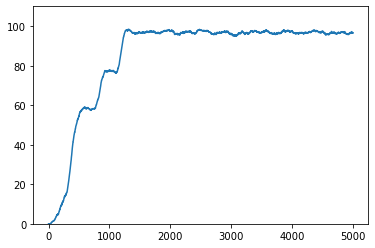

In [7]:
class memory_buffer:
    """Class for the memory buffer. Initialised with batch size and storage values."""
    def __init__(self, batch_size=64, max_storage=1000000):
        self.memory = deque([])
        self.batch_size = batch_size
        self.storage_cap = max_storage
    
    def add_memory(self, new_memory):
        """Function to add a (s,a,r,s) tuple to the memory buffer.
           If the memory buffer is at capacity, delete a memory."""
        if len(self.memory) >= self.storage_cap:
            # Memory from left of deque is deleted, new one added.
            self.memory.popleft()
            self.memory.append(new_memory)
        else:
            # New memory added.
            self.memory.append(new_memory)
    
    def fetch_batch(self):
        """Returns a list of the batch size number of samples."""
        return random.sample(self.memory, self.batch_size)


def frozen_lake(episodes, render=False, training=True):
    env = gymnasium.make("FrozenLake-v1", map_name="8x8", is_slippery=False, render_mode="human" if render else None) 
    actions = [0,1,2,3] # Actions the agent may take
    if training:
        q_table = np.zeros((env.observation_space.n, env.action_space.n))  # 64 states, 4 actions
        epsilon = 0.5 # The e-greedy randomisation starting rate.
        decay = 0.001  # Decay rate of epsilon each episode
        discount = 0.9
        learning_rate = 0.9 # Learning rate (new_q = (1- lr)*old_q + (lr)*new_q)
        
        # Statistic variables
        steps = 0
        episodes_completed = 0
        violations = 0
        
    reward_per_episode = []
    replay_experience = memory_buffer()
    
    for i in range(episodes):
        state = env.reset()[0]  # Top left is where person will be ([0])
        terminated = False  # True is falls in hole or reaches goal
        truncated = False  # True if actions goes over 200
        reward = 0

        while not terminated and not truncated:
            if random.uniform(0, 1) > epsilon and any(q_table[state]):
                # Do the q-table action if one is available (if all q_table values are 0, no action is better than any other.)
                action = np.argmax(q_table[state])
                steps += 1 # Increment step counter
            else:
                # Random action
                action = env.action_space.sample() # # 0=left, 1=down, 2=right, 3=up
                steps += 1 # Increment step counter

            # Take action
            new_state, reward, terminated, truncated, info = env.step(action)
            
            # Add memory to the memory buffer.
            replay_experience.add_memory((state, action, reward, new_state)) # Check if bracket are redundant
            
            # Update q-table
            q_table[state, action] = (1 - learning_rate) * q_table[state, action] + learning_rate * (reward + discount * np.max(q_table[new_state, :]))
            
            # New state becomes current state.
            state = new_state
            
            if i > 10:
                # Update q-tables from batch from memory buffer.
                for m in replay_experience.fetch_batch():
                    d_state, d_action, d_reward, d_new_state = m # Split out tuple then update q-tabel with memory.
                    q_table[d_state, d_action] = (1 - learning_rate) * q_table[d_state, d_action] + learning_rate * (d_reward + discount * np.max(q_table[d_new_state, :]))

        # Decrease epsilon after each episode to min of 0.02.
        epsilon = max(epsilon - decay, 0.02)
        
        # Track reward
        reward_per_episode.append(reward)
        if reward != 1 and not truncated:
            # No reward and not truncated (too many actions taken) menas that a violation has happened.
            violations += 1

        env.close()
        episodes_completed += 1
        
    print(f"Number of steps taken {steps}, Violations: {violations}")
                  
    return sum_rewards(reward_per_episode, episodes_completed), violations


t1 = time.time() # Start timer

all_rewards = []
all_violations = []
training_episodes = 5000
training_runs = 10
for i in range(training_runs):
    rewards, violations = frozen_lake(training_episodes)
    all_rewards.append(rewards)
    all_violations.append(violations)
t2 = time.time() # Stop timer
time_taken = t2 - t1 # Time taken
print(f'Elapsed time is {time_taken:.2f} seconds.')
print("Average violations per run: ", sum(all_violations)/training_runs)

average_rewards_dynq = []
for i in range(training_episodes):
    # Sum the runs and divide by number of runs to get the mean.
    total = sum([j[i] for j in all_rewards])
    average_rewards_dynq.append(total/training_runs)

plt.plot(average_rewards_dynq)
plt.ylim(0, 110)
plt.show()

### Graph of results

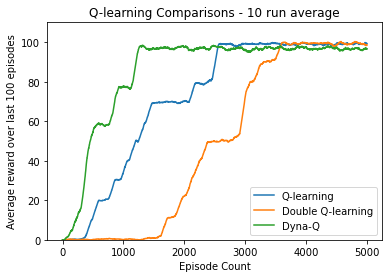

In [8]:
plt.title("Q-learning Comparisons - 10 run average")
plt.xlabel("Episode Count")
plt.ylabel("Average reward over last 100 episodes")
plt.plot(average_rewards, label="Q-learning")
plt.plot(average_rewards_dq, label="Double Q-learning")
plt.plot(average_rewards_dynq, label="Dyna-Q ")
plt.legend(loc="lower right")
plt.ylim(0, 110)
plt.show()